In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0,'../../modules')

In [4]:
import numpy as np
import common_plots
import plotly.graph_objects as go

# The Expectation-Maximization algorithm
The Em algorithm is used to improve the estimate of model parameters $\theta$. There are two steps to this. Firstly, a distribution is found over all unknown/missing values using an inference algorithm. Then secondly, the model parameters are maximized using that distribution. The origins come from the Evidence Lower Bound (ELBO):
### ELBO EM algorithm derivation:
Say we have model parameters $\theta$, observed data $X$ and unobserved data $Z$. We want to know the log probability of $P(X|\theta)$. We have a distribution $Q(Z)$ which crucially doesn't depend on $X$ or $\theta$:
$$
\begin{aligned}
    \log P(X|\theta)&=\sum_Z Q(Z) \log P(X|\theta)\\
    \log P(X|\theta)&=\sum_Z Q(Z) \log\frac{P(X,\theta)}{P(\theta)}\\
    \log P(X|\theta)&=\sum_Z Q(Z) \log\frac{P(Z,X,\theta)P(X,\theta)}{P(Z,X,\theta)P(\theta)}\\
    \log P(X|\theta)&=\sum_Z Q(Z) \log\frac{P(Z,X|\theta)}{P(Z|X,\theta)}\\
    \log P(X|\theta)&=\sum_Z Q(Z) \log \bigg( \frac{Q(Z)}{P(Z|X,\theta)}\frac{P(Z,X,\theta)}{Q(Z)} \bigg)\\
    \log P(X|\theta)&=\sum_Z Q(Z) \bigg( \log \frac{Q(Z)}{P(Z|X,\theta)} + \log \frac{P(Z,X|\theta)}{Q(Z)} \bigg)\\
    \log P(X|\theta)&=\sum_Z Q(Z) \log \frac{Q(Z)}{P(Z|X,\theta)}+\sum_Z Q(Z) \log \frac{P(Z,X|\theta)}{Q(Z)} \\
    \log P(X|\theta)&=KL(Q(Z)||P(Z|X,\theta))+\sum_Z Q(Z) \log \frac{P(Z,X|\theta)}{Q(Z)}
\end{aligned}
$$
The Kullback-Leibler divergence is a measure of the difference between two distributions $P$ and $Q$: $$KL(Q||P)=\sum_x Q(x)\log \frac{Q(x)}{P(x)}$$
The divergence can be thought as the average difference in numbers of  bits required to encode samples from distribution $P$ using a code made with distribution $Q$ instead. When the two distributions are the same, then the divergence is 0. The above formula suggests an iterative algorithm for learning $\theta$. Firstly, we get $KL(Q(Z)||P(Z|X,\theta))$ to 0 by setting $Q(Z)$ to the infered values $P(Z|X,\theta)$ for the current $\theta$. This makes it so:
$$\log P(X|\theta)=\sum_Z Q(Z) \log \frac{P(Z,X|\theta)}{Q(Z)}$$
This means any changes to $\theta$ which increase this quantity are guaranteed to push up the log likelihood. This can also be rewritten:
$$\log P(X|\theta)=\sum_Z Q(Z) \log{P(Z,X|\theta)}-\sum_Z Q(Z) \log{Q(Z)}$$
As the second term on the right is the entropy of $Q$ and doesn't depend on $\theta$, so we only have to care about the first term which is just the weighted likelihood knowing $Z$ and $X$ across all $Z$.

### EM for a mixture model
In a mixture model the probability of a given point is the weighted sum of the probabilities of individual models. An individual model is parameterized by $\phi_k$ and the weight of that model is $w_k$. The joint parameter set of $\phi_k$ and $w_k$ is $\theta_k$ with the full set of parameters refered to as $\theta$. In a mixutre of Gaussians $\phi$ would refer to the means and covariances. The values $Z$ are the latent variables, the assignment of which points to which cluster. $X$ is the data. <br>
We know $p(Z|X,\theta)$. The probability of a single data point coming from a given model is $w_i P(X_j|\phi_i)$, so $Z$ is just those values, normalized to sum to 1 over all models. <br>
We also know $p(X|Z,\theta)$ is simply the probability for the associated model $w_i P(X_j|\phi_i)$ where $i$ is the value in $Z_j$. The maximum likelihood of $\phi$ given $Z$ is to do a weighted fit of all points, with the weighting given by the value $Q(Z)$. <br>
**Example:** Mixture of Gaussians

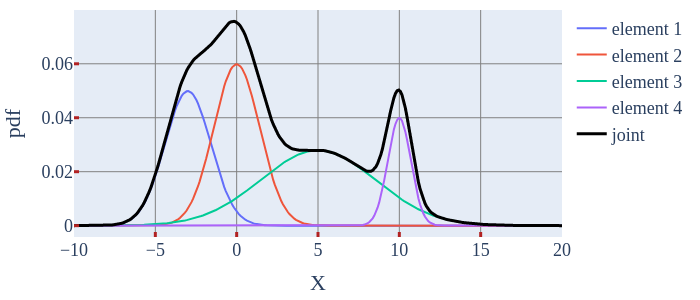

In [123]:
# make truth
true_means = [-3,0,5,10]
true_sigmas = [2,2,5,1]
true_weights = [0.25,0.3,0.35,0.1]
true_fig = common_plots.plot_1D_MoG(true_means,true_sigmas,true_weights)
true_fig.show(renderer="png",width=700,height=300)

In [124]:
# make true samples
samples = []
for i in range(10000):
    k = np.random.choice(np.arange(len(true_weights)),p=true_weights)
    mean = true_means[k]
    sigma = true_sigmas[k]
    sample = np.random.normal(mean,sigma)
    samples.append(sample)
samples = np.array(samples)

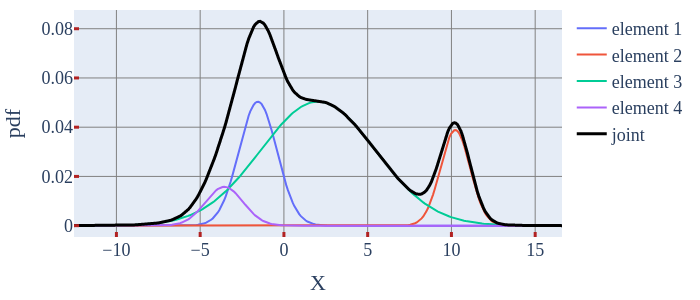

In [131]:
# make learned parameters
learned_means = np.random.uniform(np.min(samples),np.max(samples),len(true_means))
learned_sigmas = np.repeat(np.std(samples)/2,len(true_means))
learned_weights = np.random.rand(len(true_means))
learned_weights = learned_weights/np.sum(learned_weights)

for epoch in range(10):
    # E step
    Z = np.zeros((len(samples),len(true_means)))
    for k in range(len(true_means)):
        mean = learned_means[k]
        sigma = learned_sigmas[k]
        pdf_exp_part = np.exp(-0.5*((samples-mean)**2)/(sigma**2))
        pdf_norm_part = (1/np.sqrt(2*np.pi*sigma**2))
        pdf = pdf_norm_part*pdf_exp_part
        Z[:,k]=pdf*learned_weights[k]
    Z = Z/np.sum(Z,axis=1).reshape(-1,1)
    # M step
    learned_weights = np.sum(Z,axis=0)/np.sum(Z)
    for k in range(len(true_means)):
        learned_means[k] = np.sum(samples*Z[:,k])/np.sum(Z[:,k])
        learned_sigmas[k] = np.sqrt(np.sum(Z[:,k]*(samples-learned_means[k])**2)/np.sum(Z[:,k]))
learned_fig = common_plots.plot_1D_MoG(learned_means,learned_sigmas,learned_weights)
learned_fig.show(renderer="png",width=700,height=300)

In [132]:
# make learned samples
learned_samples = []
for i in range(10000):
    k = np.random.choice(np.arange(len(true_weights)),p=learned_weights)
    mean = learned_means[k]
    sigma = learned_sigmas[k]
    sample = np.random.normal(mean,sigma)
    learned_samples.append(sample)
learned_samples = np.array(learned_samples)

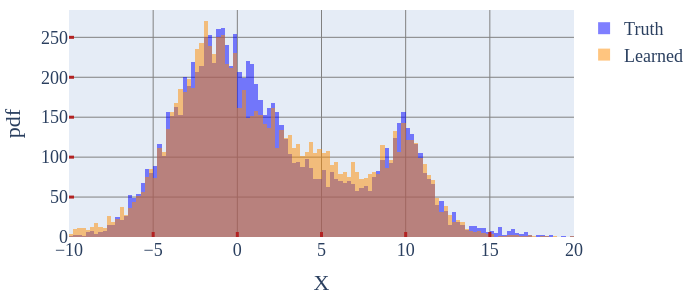

In [133]:
# show sample hist
true_fig_hist = go.Figure(data=[go.Histogram(x=samples,
                                             xbins=dict(start=-10,end=20,size=0.25),
                                             marker_color='blue',
                                             name="Truth"),
                               go.Histogram(x=learned_samples,
                                             xbins=dict(start=-10,end=20,size=0.25),
                                             marker_color='darkorange',
                                             name="Learned")])
true_fig_hist = common_plots.set_basic_layout(true_fig_hist)
true_fig_hist.update_layout(xaxis_title="X",yaxis_title="pdf")
true_fig_hist.update_layout(barmode='overlay')
true_fig_hist.update_traces(opacity=0.5)
true_fig_hist.show(renderer="png",width=700,height=300)